# Text Spam Classification

### Environment Setup

In [1]:
import time
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

import string
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier


from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import make_scorer, classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc

## Data Understanding

### Dataset Information

In [2]:
df = pd.read_csv('spam.csv')
df.rename(columns={'v1': 'class', 'v2': 'text'}, inplace=True)
df = df[['text', 'class']]

display(df.head())
df.info()

,text,class
0,"Go until jurong point, crazy.. Available only ...",ham
1,Ok lar... Joking wif u oni...,ham
2,Free entry in 2 a wkly comp to win FA Cup fina...,spam
3,U dun say so early hor... U c already then say...,ham
4,"Nah I don't think he goes to usf, he lives aro...",ham


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5574 entries, 0 to 5573
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    5573 non-null   object
 1   class   5574 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


### Dataset Description

0. **text** - text message received
1. **spam** - text class

### Missing Values

In [3]:
df.isna().sum()

text     1
class    0
dtype: int64

### Descriptive Statistics

In [4]:
df.describe()

,text,class
count,5573,5574
unique,5170,3
top,"Sorry, I'll call later",ham
freq,30,4825


### Key Findings

- 5,573 rows (messages).
- 1 missing value, to be removed.
- 3 unique values in a binary class, need to standardise values.
- More ham than spam messages.

In [5]:
df.dropna(inplace=True)
df['class'].unique() # array(['ham', 'spam', 'ham"""'], dtype=object)
df['class'].replace('ham"""', 'ham', inplace=True)
df.describe()

,text,class
count,5573,5573
unique,5170,2
top,"Sorry, I'll call later",ham
freq,30,4826


## Exploratory Data Analysis


**Class Distribution**

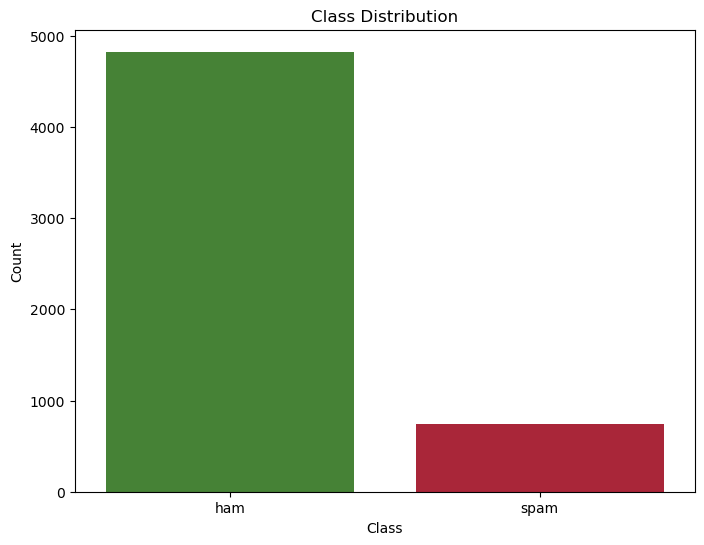

Ham Percentage: 86.6%
Spam Percentage: 13.4%


In [6]:
plt.figure(figsize=(8, 6))
palette_spamham = {'ham': '#3f8f29', 'spam': '#bf1029'}
sns.countplot(x='class', data=df, hue='class', palette=palette_spamham)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.show()

ratio = df[df['class']=='ham']['class'].count()/df['class'].count()
print(f'Ham Percentage: {ratio*100:.1f}%')
print(f'Spam Percentage: {(1-ratio)*100:.1f}%')

**Word Clouds**

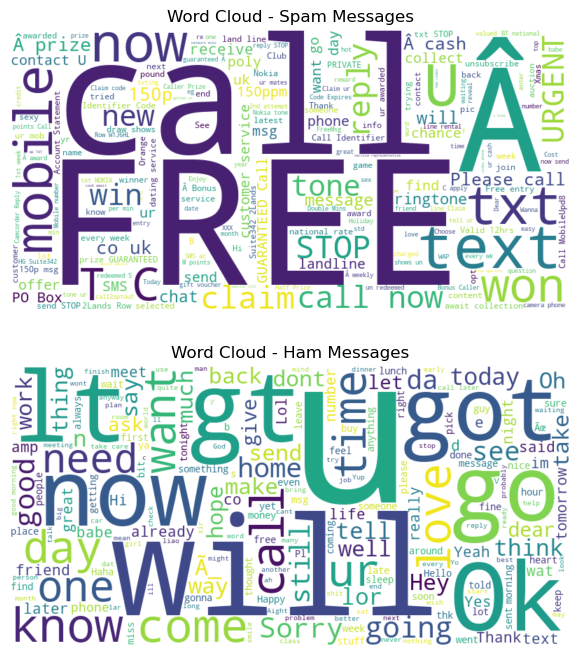

In [7]:
spam_text = ' '.join(df[df['class'] == 'spam']['text'])
wordcloud_spam = WordCloud(width=800, height=400, 
                           background_color='white',
                           random_state=42).generate(spam_text)

ham_text = ' '.join(df[df['class'] == 'ham']['text'])
wordcloud_ham = WordCloud(width=800, height=400, 
                           background_color='white',
                           random_state=42).generate(ham_text)

# Plot word clouds side by side
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.imshow(wordcloud_spam, interpolation='bilinear')
plt.title('Word Cloud - Spam Messages')
plt.axis('off')

plt.subplot(2, 1, 2)
plt.imshow(wordcloud_ham, interpolation='bilinear')
plt.title('Word Cloud - Ham Messages')
plt.axis('off')

plt.show()

**Message Lengths**

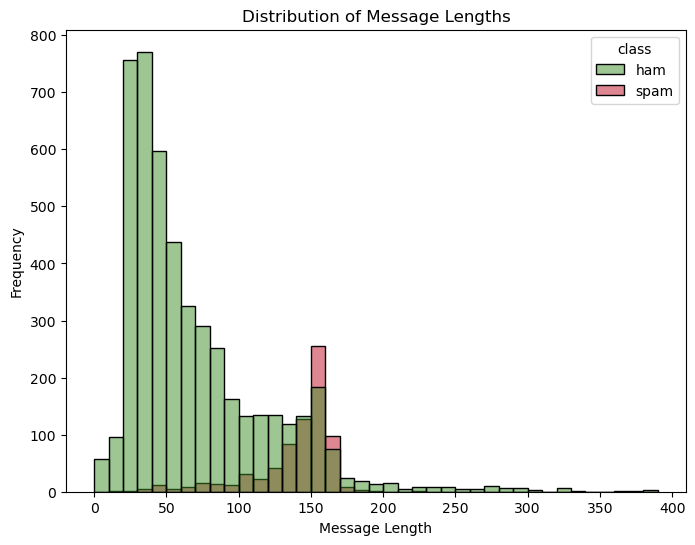

In [8]:
plt.figure(figsize=(8, 6))
sns.histplot(x=df['text'].apply(len), hue='class', 
             data=df, bins=range(0,400,10), palette=palette_spamham)
plt.xlabel('Message Length')
plt.ylabel('Frequency')
plt.title('Distribution of Message Lengths')
plt.show()

### Key findings

- Heavily imbalanced class distribution, with over six times as many ham messages than spam messages.
- Word cloud shows very different lexical usage in both classes
- Ham messages tend to be shorter in length, typically around 30 to 50 letters, while spam messages tend to be longer, around 140 to 160.

## Data Preparation

**Add Text Length Feature**

In [9]:
df['text_length'] = df['text'].apply(len)
df = df[['text', 'text_length', 'class']]
df.head()

,text,text_length,class
0,"Go until jurong point, crazy.. Available only ...",111,ham
1,Ok lar... Joking wif u oni...,29,ham
2,Free entry in 2 a wkly comp to win FA Cup fina...,155,spam
3,U dun say so early hor... U c already then say...,49,ham
4,"Nah I don't think he goes to usf, he lives aro...",61,ham


**Remove Punctuation**

In [10]:
remove_punctuation = lambda x: ''.join([char for char in x if char not in string.punctuation])
df['text'] = df['text'].apply(remove_punctuation)
df['text'].head()

0    Go until jurong point crazy Available only in ...
1                              Ok lar Joking wif u oni
2    Free entry in 2 a wkly comp to win FA Cup fina...
3          U dun say so early hor U c already then say
4    Nah I dont think he goes to usf he lives aroun...
Name: text, dtype: object

**Remove Stopwords**

In [11]:
stopwords = set(stopwords.words('english'))
remove_stopwords = lambda x: ' '.join([word for word in x.split() if word not in stopwords])
df['text'] = df['text'].apply(remove_stopwords)
df['text'].head()

0    Go jurong point crazy Available bugis n great ...
1                              Ok lar Joking wif u oni
2    Free entry 2 wkly comp win FA Cup final tkts 2...
3                  U dun say early hor U c already say
4        Nah I dont think goes usf lives around though
Name: text, dtype: object

**Lowercase Standardisation**

In [12]:
df['text'] = df['text'].str.lower()
df['text'].head()

0    go jurong point crazy available bugis n great ...
1                              ok lar joking wif u oni
2    free entry 2 wkly comp win fa cup final tkts 2...
3                  u dun say early hor u c already say
4        nah i dont think goes usf lives around though
Name: text, dtype: object

**Feature Extraction**

In [13]:
df['class'] = df['class'].map({'spam': 1, 'ham': 0})
y = df['class']

vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df['text'])
X_combined = hstack([X, df['text_length'].values.reshape(-1, 1)])

### Summary of Data Preparation

- Add text length feature
- Remove punctuation
- Remove stopwords
- Standardised words to lowercase
- Transformed raw text into a numerical representation using Bag of Words 

## Modeling

### Model Development

**Train-test Split**

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.3, random_state=42)

**Model Training and Evaluation Function**

In [15]:
metrics_df = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])
f1_scorer = make_scorer(f1_score, average='weighted')
skfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

def train_and_evaluate(name, model, model_params):
    print('Algorithm:',name)
    start_time = time.time()
    
    grid_search = GridSearchCV(model, model_params, scoring='accuracy', 
                               cv=skfold.split(X_train, y_train), n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    end_time = time.time()
    elapsed_time = end_time - start_time
    
    print(f'Elapsed time: {elapsed_time:.2f}s')
    print('Best parameters:', grid_search.best_params_)
    print('')
    
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    
    accuracy = round(accuracy_score(y_test, y_pred) * 100, 2)
    precision = round(precision_score(y_test, y_pred, average='weighted') * 100, 2)
    recall = round(recall_score(y_test, y_pred, average='weighted') * 100, 2)
    f1 = round(f1_score(y_test, y_pred, average='weighted') * 100, 2)
    
    metrics_df.loc[len(metrics_df)] = [name, accuracy, precision, recall, f1]

**Model Parameters and Training**

In [16]:
lgr_params = {
    'penalty': ['l2'],
    'C': [1, 5, 10],
    'max_iter': [4000, 5000, 6000],
    'random_state': [42]
}

svm_params = {
    'C': [1, 5, 10],
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'random_state': [42]
}

nb_params = {
    'alpha': [0.1, 0.25, 0.5, 0.75, 1.0]
}

rfr_params = {
    'n_estimators': [100, 200, 300],
    'criterion': ['gini', 'entropy'],
    'random_state': [42]
}

gbo_params = {
    'learning_rate': [0.1, 0.5, 1],
    'n_estimators': [100, 200, 300],
    'random_state': [42]
}

models = {
    'Logistic Regression': (LogisticRegression(), lgr_params),
    #'Support Vector Machine': (SVC(), svm_params),
    #'Naive Bayes': (MultinomialNB(), nb_params),
    #'Random Forest': (RandomForestClassifier(), rfr_params),
    #'Gradient Boosting': (GradientBoostingClassifier(), gbo_params),
}

for name, (model, params) in models.items():
    train_and_evaluate(name, model, params)

Algorithm: Logistic Regression
Elapsed time: 4.80s
Best parameters: {'C': 5, 'max_iter': 4000, 'penalty': 'l2', 'random_state': 42}



**Model Evaluation**

In [17]:
metrics_df

,Model,Accuracy,Precision,Recall,F1 Score
0,Logistic Regression,98.27,98.25,98.27,98.25


- All models performed exceptionally well across different metrics.
- Ensemble methods performed slightly poorer compared to the rest.
- We will use Logistic Regression since it has the highest F1 score (as well as other scoring metrics).

### Optimised Model Training and Evaluation

**Model Training**

In [18]:
lgr_best_params = {'C': 10, 'max_iter': 4000, 'penalty': 'l2', 'random_state': 42}
best_model = LogisticRegression(**lgr_best_params)
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

**Confusion Matrix**

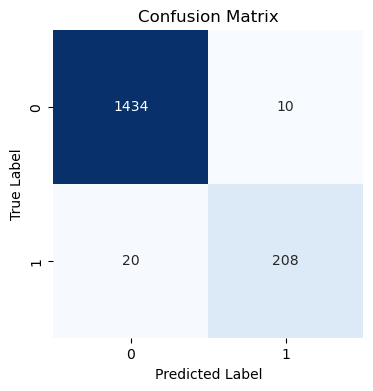

In [19]:
plt.figure(figsize=(4, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=best_model.classes_, yticklabels=best_model.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

- 1434 messages were correctly predicted as ham.
- 10 messages were incorrectly predicted as ham.
- 20 messages were incorrectly predicted as spam.
- 208 messages were correctly predicted as spam.

**Classification Report**

In [20]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1444
           1       0.95      0.91      0.93       228

    accuracy                           0.98      1672
   macro avg       0.97      0.95      0.96      1672
weighted avg       0.98      0.98      0.98      1672



- Model seems to perform very well, especially for class 0 (ham) where both precision and recall are high at 99%. 
- For class 1, recall is slightly lower, indicating that the model may miss some instances of class 1 (spam).
- The overall accuracy of 98% suggests good overall performance.

**ROC and AUC**

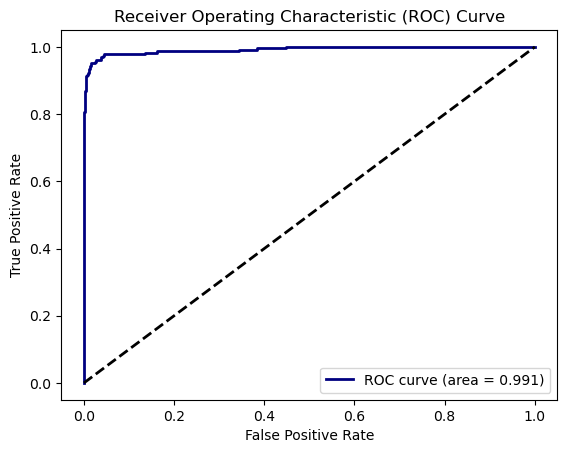

In [21]:
y_score = best_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='navy', lw=2, label='ROC curve (area = {:.3f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

- AUC score of 0.991 indicates that the model has an excellent discrimination between the ham and spam messages.

# Results and Conclusion

In this text spam classification project, we trained a logistic regression model to distinguish between ham and spam messages. The model exhibited commendable performance across various metrics, showcasing its effectiveness in discriminating between positive and negative instances.

Class-specific performance: The model demonstrated exceptional precision and recall for ham messages, achieving 99% in both metrics. This indicates a high accuracy in correctly identifying non-spam messages.
For spam messages, the model maintained a strong precision of 95% but exhibited a slightly lower recall of 91%. While the precision ensures a low false positive rate, the recall indicates a moderate rate of false negatives for spam messages.

Model performance: The overall accuracy of the model reached an impressive 98%, reflecting its robust performance in classifying messages into ham and spam categories.
The AUC-ROC score of 0.991 highlighted the model's excellent ability to distinguish between positive and negative classes.

Considerations and improvement: Balancing precision and recall may require adjustments to the classification threshold, with a potential focus on minimizing false negatives for spam messages. Continuous monitoring and updating of the model may be valuable to adapt to evolving patterns in text messages.

### Test examples

In [22]:
def spam_or_not(string):
    string_vectorized = vectorizer.transform([string]).toarray()
    string_length = len(string)
    string_with_length = np.hstack([string_vectorized, np.array([[string_length]])])
    string_with_length = string_with_length.reshape(1, -1)
    prediction = best_model.predict(string_with_length)
    probability = best_model.predict_proba(string_with_length)[:, 1]
    if prediction == [1]:
        print(f'Spam Message\nConfidence: {probability[0]*100:.1f}%')
    else:
        print(f'Ham Message \nConfidence: {(1-probability[0])*100:.1f}%')

In [23]:
text_msg = 'You won a $1000 gift card from OCBC bank. Claim it now at https://giveaway2024.ocbc.com.sg.'
spam_or_not(text_msg)

Spam Message
Confidence: 74.2%


In [24]:
text_msg = 'Meeting starts in 20mins btw. I will use my laptop to present'
spam_or_not(text_msg) 

Ham Message 
Confidence: 99.4%
